# Adjusted Mayer Multiple

- Mayer Multiple is a ratio between the current Market Price and its 200 days moving average.
- It suffers from alpha decay due to the diminishing volatility of Bitcoin
- A range normalization is performed on the Mayer Multiple using quantile regression to adjust to the diminishing volatility of Bitcoin.

In [6]:
import numpy as np
import pandas as pd
import ocfinance as of
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats

## Fetch data

In [7]:
url = "https://chainexposed.com/MayerMultiple.html"
df = of.download(url)
df.dropna(inplace=True)
df

,Price,200d SMA,Mayer Multiple
Date,,,
2011-02-02,0.725435,0.181973,3.986496
2011-02-03,0.693898,0.185013,3.750532
2011-02-04,0.810959,0.188664,4.298427
2011-02-05,0.911671,0.192849,4.727390
2011-02-06,0.898000,0.196943,4.559699
...,...,...,...
2024-10-07,62416.508830,63560.928930,0.981995
2024-10-08,62126.327377,63554.128142,0.977534
2024-10-09,60615.258192,63535.398219,0.954039


## Visualize Data

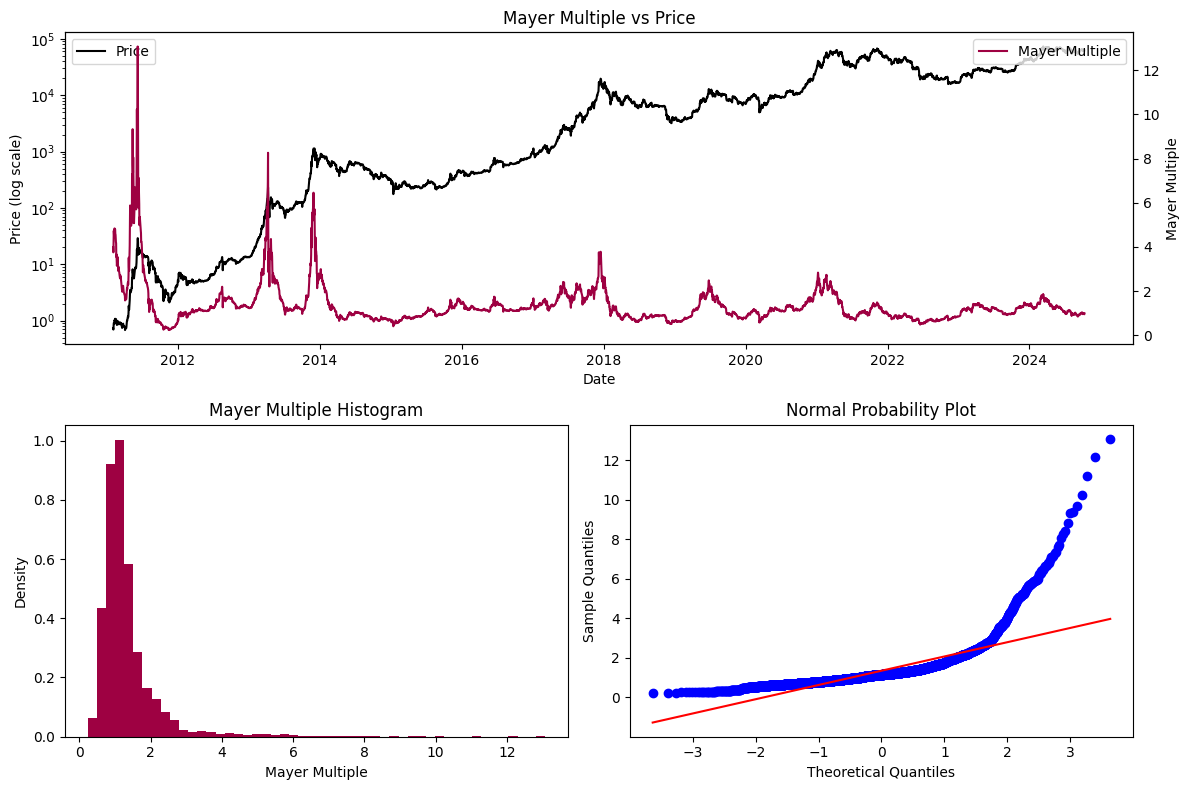

In [8]:
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 2)

# Timeseries
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(df['Price'], color='black', label='Price')
ax1.set_yscale('log')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price (log scale)')

ax2 = ax1.twinx()
ax2.plot(df['Mayer Multiple'], color='#9e0142', label='Mayer Multiple')
ax2.set_ylabel('Mayer Multiple')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.set_title("Mayer Multiple vs Price")

# Histogram
ax0 = fig.add_subplot(gs[1, 0])  # Second row, first column
ax0.hist(df['Mayer Multiple'], bins=50, density=True, color='#9e0142')
ax0.set_title('Mayer Multiple Histogram')
ax0.set_xlabel('Mayer Multiple')
ax0.set_ylabel('Density')

# Normal Probability Plot
ax3 = fig.add_subplot(gs[1, 1])
stats.probplot(df['Mayer Multiple'], dist="norm", plot=ax3)
ax3.set_title('Normal Probability Plot')
ax3.set_xlabel('Theoretical Quantiles')
ax3.set_ylabel('Sample Quantiles')

plt.tight_layout()
plt.show()

## Fit the Quantile Regressions

Bottom fit params: [-1.22488609e+00  1.59052298e-04]
Top fit params: [ 2.06049840e+00 -3.15127633e-04]


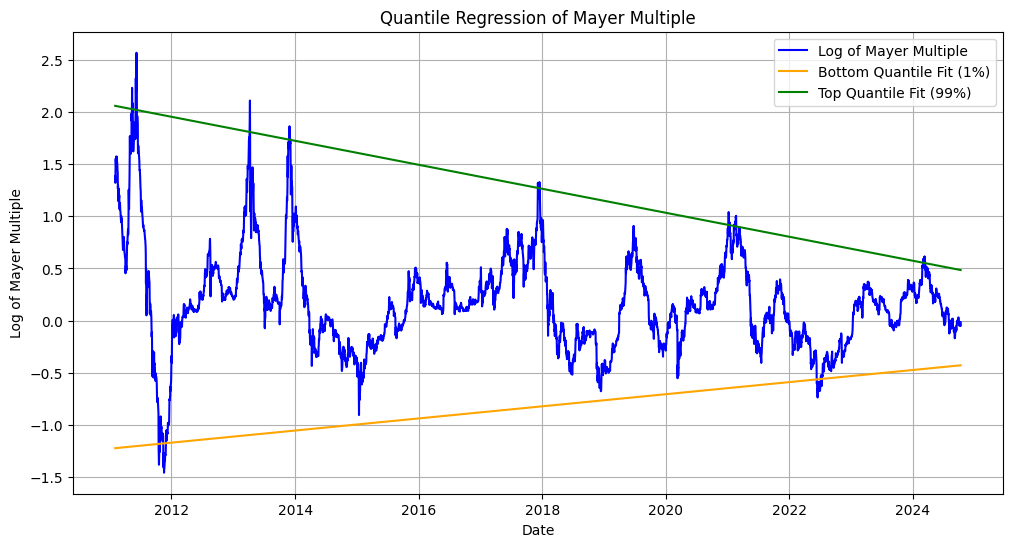

In [9]:
start_date = df.index[0]
X = np.array((df.index - start_date).days)
X_squared = X ** 2
X_with_const = sm.add_constant(X)
y = np.log(df['Mayer Multiple'].values)

model_bottom = sm.QuantReg(y, X_with_const)
results_bottom = model_bottom.fit(q=0.01)

model_top = sm.QuantReg(y, X_with_const)
results_top = model_top.fit(q=0.99)

print(f"Bottom fit params: {results_bottom.params}")
print(f"Top fit params: {results_top.params}")

y_bottom = model_bottom.predict(results_bottom.params)
y_top = model_top.predict(results_top.params)

plt.figure(figsize=(12, 6))
plt.plot(df.index, y, label='Log of Mayer Multiple', color='blue')
plt.plot(df.index, y_bottom, label='Bottom Quantile Fit (1%)', color='orange')
plt.plot(df.index, y_top, label='Top Quantile Fit (99%)', color='green')
plt.title('Quantile Regression of Mayer Multiple')
plt.xlabel('Date')
plt.ylabel('Log of Mayer Multiple')
plt.legend()
plt.grid()
plt.show()

## Calculate the Adjusted Mayer Multiple

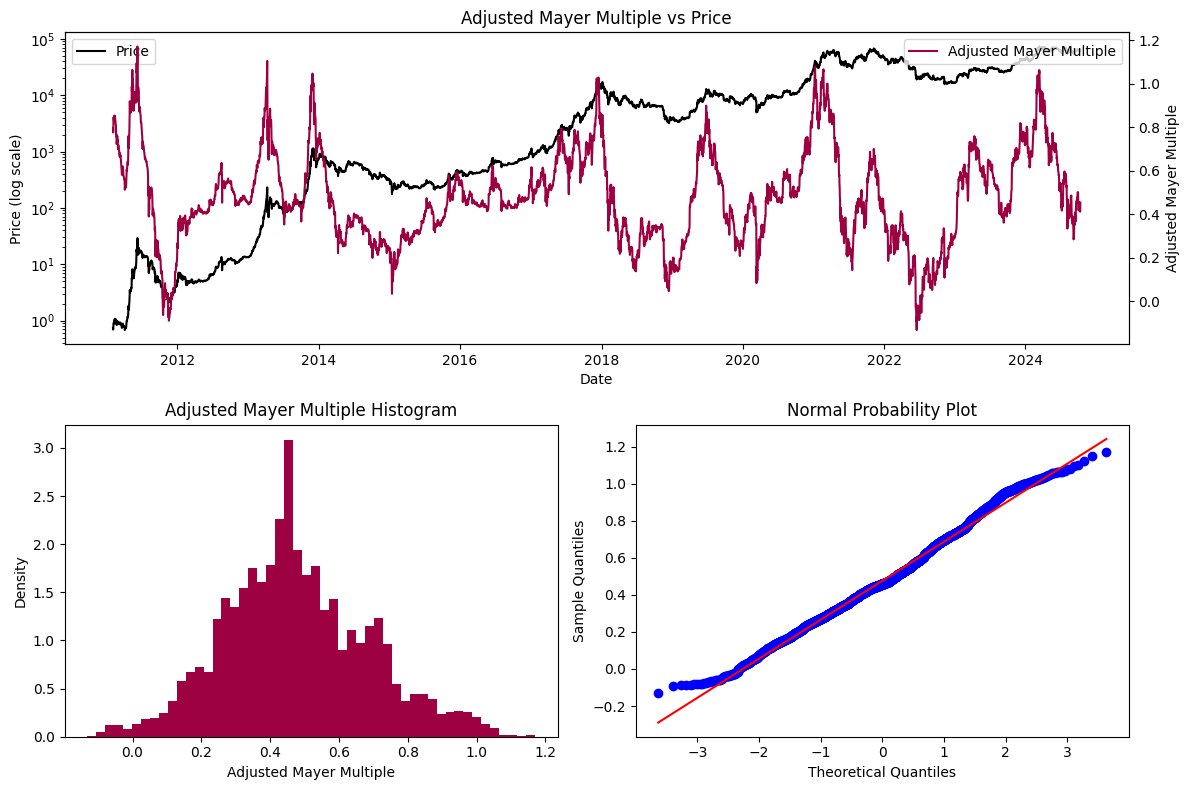

In [10]:
df['Adjusted Mayer Multiple'] = (y - y_bottom) / (y_top - y_bottom)

# Plot
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 2)

# Timeseries
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(df['Price'], color='black', label='Price')
ax1.set_yscale('log')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price (log scale)')

ax2 = ax1.twinx()
ax2.plot(df['Adjusted Mayer Multiple'], color='#9e0142', label='Adjusted Mayer Multiple')
ax2.set_ylabel('Adjusted Mayer Multiple')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.set_title("Adjusted Mayer Multiple vs Price")

# Histogram
ax0 = fig.add_subplot(gs[1, 0])  # Second row, first column
ax0.hist(df['Adjusted Mayer Multiple'], bins=50, density=True, color='#9e0142')
ax0.set_title('Adjusted Mayer Multiple Histogram')
ax0.set_xlabel('Adjusted Mayer Multiple')
ax0.set_ylabel('Density')

# Normal Probability Plot
ax3 = fig.add_subplot(gs[1, 1])
stats.probplot(df['Adjusted Mayer Multiple'], dist="norm", plot=ax3)
ax3.set_title('Normal Probability Plot')
ax3.set_xlabel('Theoretical Quantiles')
ax3.set_ylabel('Sample Quantiles')

plt.tight_layout()
plt.show()

## Conclusion

Apart from the one outlier in 2022, the adjusted mayer multiple provides a new life for this alpha decayed indicator.